# Convolutional Neural Networks

In this step, we will train the mnist data with Convolutional Neural Networks, a.k.a CNNs.

Convolutional Neural Network is a very popular deep learning method especially in the fields of computer vision.

Contrast to DBN which tries to resolve the overfitting issue with initialization, CNN tries to address this problem with reduced model complexity.

The convolution layer and pooling layer drastically reduces the model complexity compared to other deep learning methods, and consequently prevents overfitting in an extremely efficient way.

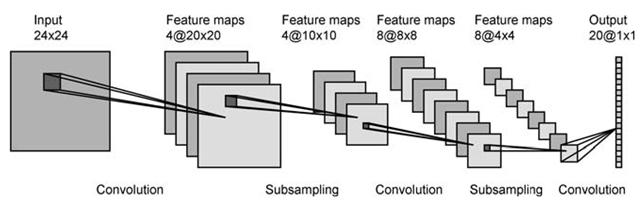

In [1]:
itorch.image('./ConvolutionalNeuralNetwork/CNN.png')

# Convolution

As you can see above, CNN mainly features what we call 'filters' and convolves it around the entire image.

By every step of convolution, a particular feature is calculated, and this will eventually form a spacial map, which we call 'feature maps'.

The convolution steps are as below

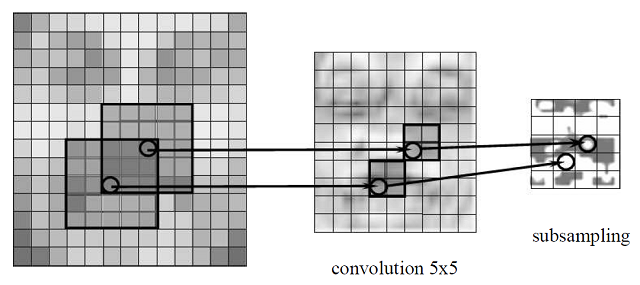

In [2]:
itorch.image('./ConvolutionalNeuralNetwork/convolution.png')

# CIFAR-10 dataset

CIFAR-10 is a very popular toy dataset mostly used to get the basic idea of image classification.

CIFAR-10 dataset consists of 60,000 32x32 RGB images with 3 channels, with 6000 images per class.

This again splits into 50000 training images and 10000 test images.

It has total 10 classes, being 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck' (which is in alphabetical order).

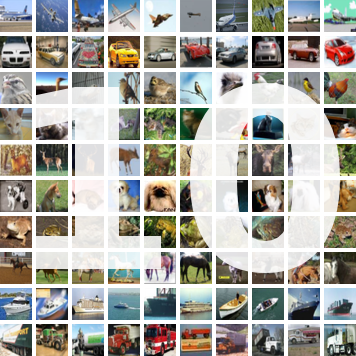

In [3]:
itorch.image('./ConvolutionalNeuralNetwork/cifar10_image.png')

# Preparing the dataset

Now, prepare the CIFAR-10 dataset by running the following codes.

In [4]:
print '============================================='
print '=> Downloading CIFAR-10 dataset...'
print '============================================='

tar = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/cifar10.t7.tgz'

if not paths.dirp('cifar-10-batches-t7') then
   os.execute('wget ' .. tar)
   os.execute('tar xvf ' .. paths.basename(tar))
end

=> Downloading CIFAR-10 dataset...	


# Organizing the dataset

Now, we will organize the downloaded dataset into a Tensor form we can actually use.

As the image is in color, we will form 3 channels each representing the color channel 'R', 'G', 'B'.

The training data will be in the size of 50,000 and the testing data will be in the size of 10,000.

In [5]:
print '============================================='
print '=> Organizing CIFAR-10 dataset...'
print '============================================='

trainSize = 50000
testSize = 10000

trainData = {
   data = torch.Tensor(trainSize, 3*32*32),
   labels = torch.Tensor(trainSize),
   size = trainSize
}

for i = 0,4 do
   subset = torch.load('cifar-10-batches-t7/data_batch_' .. (i+1) .. '.t7', 'ascii')
   trainData.data[{ {i*10000+1, (i+1)*10000} }] = subset.data:t()
   trainData.labels[{ {i*10000+1, (i+1)*10000} }] = subset.labels
end

trainData.labels = trainData.labels + 1 -- as torch index starts with 1, not 0

subset = torch.load('cifar-10-batches-t7/test_batch.t7', 'ascii')
testData = {
   data = subset.data:t():double(),
   labels = subset.labels[1]:double(),
   size = testSize
}
testData.labels = testData.labels + 1

trainData.data = trainData.data:reshape(trainSize,3,32,32)
testData.data = testData.data:reshape(testSize,3,32,32)

=> Organizing CIFAR-10 dataset...	


In [6]:
print '============================================='
print("=> Checking Data...")
print '=============================================\n'
print("Training Set : ")
print(trainData)
print("Training Label : ")
print(trainData.labels:size())
print("Test Set : ")
print(testData)
print("Test Label : ")
print(testData.labels:size())

=> Checking Data...	
	
Training Set : 	
{
  data : DoubleTensor - size: 50000x3x32x32
  size : 50000
  labels : DoubleTensor - size: 50000
}
Training Label : 	
 50000
[torch.LongStorage of size 1]

Test Set : 	
{
  data : DoubleTensor - size: 10000x3x32x32
  size : 10000
  labels : DoubleTensor - size: 10000
}
Test Label : 	
 10000
[torch.LongStorage of size 1]



=> Visualizing Data...	
	
Training data:	


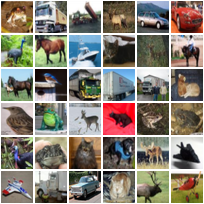

Test data:	


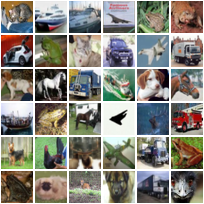

In [7]:
print '============================================='
print('=> Visualizing Data...')
print '=============================================\n'

if itorch then
   print('Training data:')
   itorch.image(trainData.data[{ {1,36} }])
   print('Test data:')
   itorch.image(testData.data[{ {1,36} }])
end

# Batch Normalization

Brad Neubreg introduced 2 important facts in NIPS(Neural Information Processing Systems) conference.

1. Almost every state of the art system implements LSTM.

2. Now, Batch normalization is not an option, but a necessity.

Then, what is batch normalization?

The main object of this tutorial is to allow new learners to understand deep learning methods without complicated math/computer science explanation.

Batch Normalization simply aims to equalize the characteristics of each layer's input.

It accelerates and stabilizes the training process drastically.

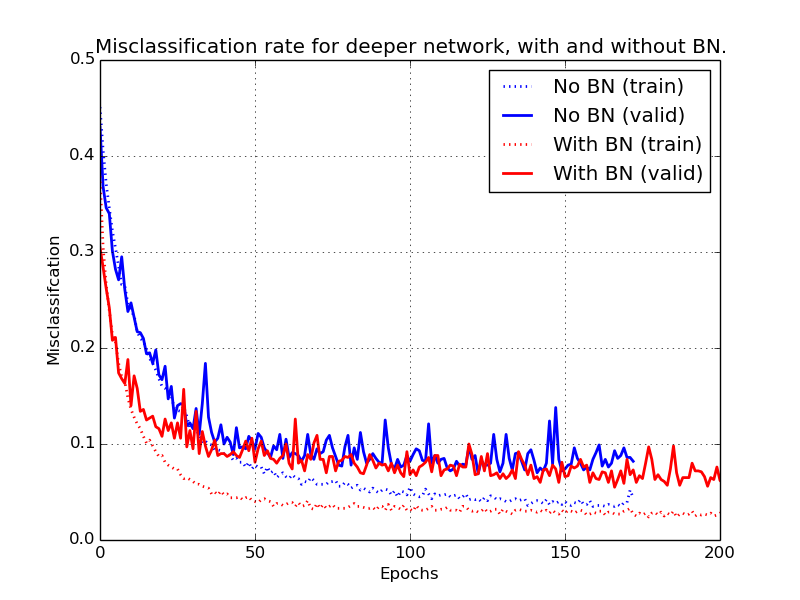

In [19]:
itorch.image('./ConvolutionalNeuralNetwork/bn.png')

* As you can see in the above with kaggle 'cat vs dog' training, you can see that simply adding the batch normalization layer improved both speed and stability in a significant scale.

# Model definition

We will use a model with each Convolution layers, Batch Normalization, Activation function, Max pooling, and will add a single softmax layer on the output.

As an input, we will now load the (3, 32, 32) image without any spreading or augmentation.

Also, we will implement the 'Batch Normalization' concept introduced right above.

In [8]:
require 'torch'
require 'nn'
require 'optim'
require 'cutorch'
require 'cudnn'
require 'cunn'

In [9]:
-- Layer definition
input_channel = 3
filter_num_1 = 64
filter_num_2 = 128
fully_connected_layer = 256

-- convolution options
filter_size = 3
conv_stride = 1
padding_size = math.floor(filter_size/2) -- zero padding

-- max pooling options
pooling_size = 3
pooling_stride = 2
pooling_padding = math.floor(pooling_size/2)

-- Model definition

-- Conv block #1
model = nn.Sequential()
model:add(nn.SpatialConvolution(
        input_channel,
        filter_num_1,
        filter_size,
        filter_size,
        conv_stride,
        conv_stride,
        padding_size,
        padding_size
    )) -- Current spatial size = (32x32)
model:add(nn.SpatialBatchNormalization(filter_num_1))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(
        pooling_size,
        pooling_size,
        pooling_stride,
        pooling_stride,
        pooling_padding,
        pooling_padding
    )) -- Current spatial size = (16x16)

-- Conv block #2
model:add(nn.SpatialConvolution(
        filter_num_1,
        filter_num_2,
        filter_size,
        filter_size,
        conv_stride,
        conv_stride,
        padding_size,
        padding_size
    )) -- Current spatial size = (16x16)
model:add(nn.SpatialBatchNormalization(filter_num_2))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(
        pooling_size,
        pooling_size,
        pooling_stride,
        pooling_stride,
        pooling_padding,
        pooling_padding
    )) -- Current spatial size = (8x8)

-- Fully connected layer
model:add(nn.View(8*8*filter_num_2))
model:add(nn.Linear(8*8*filter_num_2, fully_connected_layer))
model:add(nn.ReLU())
model:add(nn.Linear(fully_connected_layer, 10))

# Criterion definition

Torch provides various criterions enabling the user to train various models with various methods.

In this section, we will use the CrossEntropyCriterion.

In this session, we will also cover up the necessary criterions provided by Torch. 

In [10]:
criterion = nn.CrossEntropyCriterion()

# GPU function

The below codes enables the model to train on the GPU you own.

You must have already completed the GPU settings in order to 

train by this option.

You can upload the model into GPU by simply adding ':cuda()' on your code.

If you're willing to train only using your CPU environment, just add ':double()' or ':float()' on your code.

In [11]:
GPU_flag = true

if GPU_flag then
    model:cuda()
    criterion:cuda()
else
    model:double()
    criterion:double()
end

# Optimizer Definition

There are various descent algorithms other than SGD(Stochastic Gradient Descent), but we will continue to use SGD as our default optimizer.

In [12]:
sgd_params = {
   learningRate = 0.01,
   learningRateDecay = 1e-5,
   weightDecay = 1e-4,
   momentum = 0.9
}

x, dl_dx = model:getParameters()

# Mini-batch SGD

In contrast to the chapters before, from now on we're going to adapt mini-batch SGD.

Gradient Descent performs best when it's batch equals it's training size, but for many reasons and for many cases, that simply isn't possible.

So, as a median offer for Gradient Descent(Batch size = training size) and Stochastic Gradient Descent(Batch size = 1), mini-batch SGD takes a fixed amount of batches into its input.

It results in much faster and much efficient training than Stochastic Gradient Descent, with consuming much less memory than Full-batch Gradient Descent.

In this session, we will print out the current loss for a fixed internal of batches to observe the training process.

In [13]:
-- Mini-batch SGD function
mini_batch_upload = function(GPU_flag, batch_size)
    local current_loss = 0
    local count = 0
    local shuffle = torch.randperm(trainData.size)
    batch_size = batch_size or 128
    
    for t = 1,trainData.size,batch_size do
        -- setup inputs and targets for this mini-batch
        local size = math.min(t + batch_size - 1, trainData.size) - t
        if GPU_flag then
            inputs = torch.Tensor(size, 3, 32, 32):cuda()
        else
            inputs = torch.Tensor(size, 3, 32, 32)
        end
        
        -- definition of target data
        local targets = torch.Tensor(size)
        
        -- Batch iteration
        for i = 1,size do
            local input = trainData.data[shuffle[i+t]]
            if GPU_flag then
                input:cuda()
            end
            local target = trainData.labels[shuffle[i+t]]
            -- if target == 0 then target = 10 end
            inputs[i] = input
            targets[i] = target
        end
        targets:add(1)
        
        local feval = function(x_new)
            -- reset data
            if x ~= x_new then x:copy(x_new) end
            dl_dx:zero()

            -- perform mini-batch gradient descent
            local loss = criterion:forward(model:forward(inputs), targets)
            model:backward(inputs, criterion:backward(model.output, targets))

            return loss, dl_dx
        end
        
        _, fs = optim.sgd(feval, x, sgd_params)
        -- fs is a table containing value of the loss function
        -- (just 1 value for the SGD optimization)
        count = count + 1
        current_loss = current_loss + fs[1]
        if (count % 10000 == 0) then
            print(string.format(
                    ' | [%3d/50000] Training Loss = %4f', count, current_loss/count))
        end
    end

    -- normalize loss
    return current_loss / count
end

# Evaluating Dataset

Below will be the code for evaluating validation / test dataset accuracy

In [14]:
eval = function(dataset, GPU_flag, batch_size)
    local count = 0
    batch_size = batch_size or 128
    
    for i = 1,dataset.size,batch_size do
        local size = math.min(i + batch_size - 1, dataset.size) - i
        -- Important
        -- The arguement set only accepts Double Tensor as an input!
        if GPU_flag then
            inputs = dataset.data[{{i,i+size-1}}]:cuda()
        else
            inputs = dataset.data[{{i,i+size-1}}]:double()
        end
        
        -- definition of target label
        if GPU_flag then 
            local tmp = dataset.labels[{{i,i+size-1}}]:long()
            targets = torch.CudaLongTensor()
            targets:resize(tmp:size()):copy(tmp)
        else
            targets = dataset.labels[{{i,i+size-1}}]:long()
        end
        
        -- feed forward neural network
        local outputs = model:forward(inputs)
        local _, indices = torch.max(outputs, 2)
        indices:add(-1)
        local guessed_right = indices:eq(targets):sum()
        count = count + guessed_right
    end

    return count / dataset.size
end

# Training the model

Now on, we will start to train the model.

The training will be proceeded through 30 epochs, and will be trained with the parameters defined above (See 'sgd_params')

In [15]:
local epochs = 30
local last_accurcay = 0
model:zeroGradParameters() -- initialize gradient buffers in the network to 0

for i = 1,epochs do
    print(string.format(' => Epoch #%d', i))
    local loss = mini_batch_upload(GPU_flag)
    print(string.format(' | Average Loss = %4f', loss))
    local accuracy = eval(testData, GPU_flag)
    print(string.format(' | Validation accuracy : %.2f', accuracy*100)..'%\n')
    last_accuracy = accuracy
end

print("\n\nTraining Progress Finished!")
print(string.format('Final Test acc : %.2f', last_accuracy*100)..'%')

 => Epoch #1	


 | Average Loss = 1.709434	


 | Validation accuracy : 49.34%
	
 => Epoch #2	


 | Average Loss = 1.385766	


 | Validation accuracy : 53.35%
	
 => Epoch #3	


 | Average Loss = 1.255186	


 | Validation accuracy : 58.14%
	
 => Epoch #4	


 | Average Loss = 1.179828	


 | Validation accuracy : 60.28%
	
 => Epoch #5	


 | Average Loss = 1.123971	


 | Validation accuracy : 61.71%
	
 => Epoch #6	


 | Average Loss = 1.085243	


 | Validation accuracy : 62.75%
	
 => Epoch #7	


 | Average Loss = 1.051732	


 | Validation accuracy : 62.20%
	
 => Epoch #8	


 | Average Loss = 1.024241	


 | Validation accuracy : 63.20%
	
 => Epoch #9	


 | Average Loss = 0.991265	


 | Validation accuracy : 65.08%
	
 => Epoch #10	


 | Average Loss = 0.969362	


 | Validation accuracy : 65.17%
	
 => Epoch #11	


 | Average Loss = 0.948435	


 | Validation accuracy : 64.93%
	
 => Epoch #12	


 | Average Loss = 0.925453	


 | Validation accuracy : 65.92%
	
 => Epoch #13	


 | Average Loss = 0.902866	


 | Validation accuracy : 65.59%
	
 => Epoch #14	


 | Average Loss = 0.878979	


 | Validation accuracy : 66.34%
	
 => Epoch #15	


 | Average Loss = 0.859619	


 | Validation accuracy : 66.02%
	
 => Epoch #16	


 | Average Loss = 0.840101	


 | Validation accuracy : 66.57%
	
 => Epoch #17	


 | Average Loss = 0.826093	


 | Validation accuracy : 67.53%
	
 => Epoch #18	


 | Average Loss = 0.807078	


 | Validation accuracy : 67.15%
	
 => Epoch #19	


 | Average Loss = 0.788884	


 | Validation accuracy : 67.83%
	
 => Epoch #20	


 | Average Loss = 0.771306	


 | Validation accuracy : 67.80%
	
 => Epoch #21	


 | Average Loss = 0.759017	


 | Validation accuracy : 67.86%
	
 => Epoch #22	


 | Average Loss = 0.735742	


 | Validation accuracy : 67.42%
	
 => Epoch #23	


 | Average Loss = 0.726028	


 | Validation accuracy : 68.46%
	
 => Epoch #24	


 | Average Loss = 0.709415	


 | Validation accuracy : 68.52%
	
 => Epoch #25	


 | Average Loss = 0.696759	


 | Validation accuracy : 68.25%
	
 => Epoch #26	


 | Average Loss = 0.683447	


 | Validation accuracy : 68.08%
	
 => Epoch #27	


 | Average Loss = 0.670541	


 | Validation accuracy : 69.34%
	
 => Epoch #28	


 | Average Loss = 0.657045	


 | Validation accuracy : 68.47%
	
 => Epoch #29	


 | Average Loss = 0.648684	


 | Validation accuracy : 67.89%
	
 => Epoch #30	


 | Average Loss = 0.635765	


 | Validation accuracy : 68.49%
	


Training Progress Finished!	
Final Test acc : 68.49%	


# Saving the model

Now we have successfully trained the model, we will now save the model into a '.t7' data format.

Simply just run the code below.

In [16]:
torch.save('./cifar10.t7', model)

# Loading the model

After you saved your model, try to upload the weights back into your model.

Run the code below and test if the test accuracy appears same as the above.

The model will be saved in the same directory with the name 'bestmodel.t7'.

In [17]:
model = torch.load('./cifar10.t7')

In [18]:
print("Loaded Test Accuracy : "..(eval(testData, GPU_flag)*100)..'%')

Loaded Test Accuracy : 68.49%	
